## Imports

In [1]:
import os
import sys
import shutil
import xarray as xr
import hydroStats
import array
import random
import numpy as np
import csv
import geopandas as gpd
from shapely.geometry import Point

import datetime
import pandas as pd
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
from osgeo import gdal
import pandas
import cftime
import multiprocessing
import time
from configparser import ConfigParser
import glob
from subprocess import Popen, PIPE
import matplotlib.pyplot as plt
import ast

from sys import platform
import pickle
import stat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
## Set global parameter
global gen
gen = 0
WarmupDays = 0
n_station = 2 
frequen = 'd'


In [2]:
xr_obs = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope_Gauged_calibrated.nc')
xr_map = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/wmobb_basin_map.nc')

In [3]:

variable = xr.open_dataset('/work/ch0636/projects/uwares/CWatM_input/CWatM-Earth-5min/landsurface/fractionLandcover.nc')
# variable = xr.open_dataset('/work/ch0636/projects/uwares/CWatM_input/CWatM-Earth-5min/routing/kinematic/chanlength.nc')

In [4]:
# A_lon, A_lat, B_lon, B_lat = np.min(xr_map.x.values) , np.min(xr_map.y.values) , np.max(xr_map.y.values) , np.max(xr_map.y.values)
A_lon, A_lat, B_lon, B_lat = -12 , 34 , 41 , 72

land_europe = variable.sel(lat = slice(B_lat,A_lat), lon = slice(A_lon,B_lon))

In [5]:
bands = 1  # Nombre de bandes
x_size = len(land_europe.lon)  # Taille de la dimension x
y_size = len(land_europe.lat) 
data = np.ones((x_size, y_size))


for i in range(x_size) :
    for j in range(y_size) :
            data[i,j] =xr_map.sel(x=land_europe.lon[i],y=land_europe.lat[j],method='nearest').sub_basin.values
# Créer le xarray DataArray avec les coordonnées et les dimensions

/tmp/ipykernel_103866/2116537636.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[i,j] =xr_map.sel(x=land_europe.lon[i],y=land_europe.lat[j],method='nearest').sub_basin.values


In [9]:
# Définir la taille du tableau pour chaque dimension
bands = 1  # Nombre de bandes
x_size = len(land_europe.lon)  # Taille de la dimension x
y_size = len(land_europe.lon)   # Taille de la dimension y

# Créer un DataArray avec des uns


xarr = xr.DataArray(data, dims=[ 'lon', 'lat'],
                    coords={'lon': land_europe.lon,
                            'lat': land_europe.lat})

xarr.name = 'sub_basin_mask'
# Afficher le xarray DataArray créé
#map_array = xr.merge([land_europe,xarr])


## Tests on land_europe

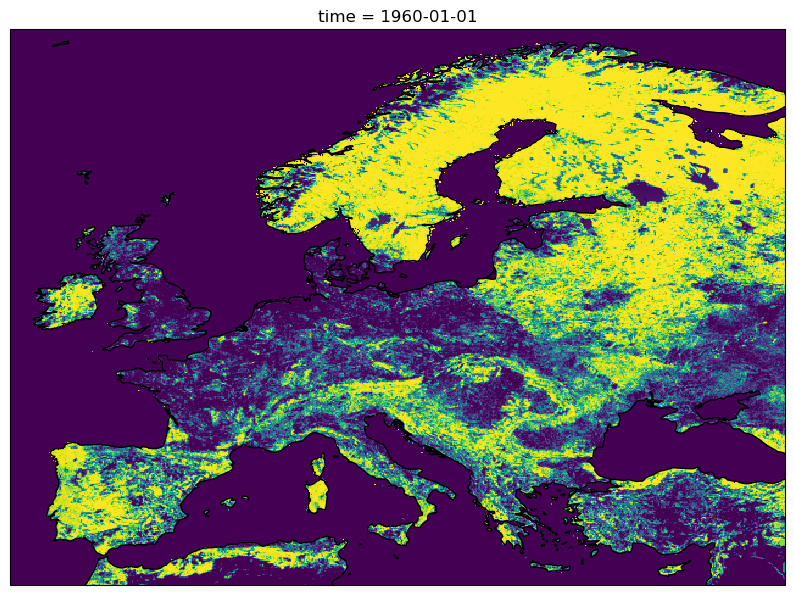

In [7]:
choosen_projection = ccrs.PlateCarree() 
list_region = np.sort(list(set(xr_map.sub_basin.values.flatten().tolist())))
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': choosen_projection})
#ax = plt.axes(projection = choosen_projection) 
ax.set_extent([A_lon, B_lon, A_lat, B_lat], crs = choosen_projection)
ax.coastlines(linewidth=1, linestyle='-')
for i in list_region:
    land_masked=land_europe*xarr.where(xarr==i)/i 
    land_masked.fracforest.isel(time=0).plot(ax=ax,add_colorbar=False)

0.009115860808374855
0.04457915288699173
0.524310365040317
0.17258959625239817
0.1170596069078849
0.31164632827810235
0.2448000007781583
0.6027969209400894
0.2361316832551172
0.0
0.8827146730433034
0.5335135266315404
0.21197321985485515
0.13461246261390564
0.08236625027299808
0.10213006299020208
0.13864475322121067
0.11099272496731073
0.6461073239744961
0.8012986923719575
0.5478046241463737
0.7560102695976789
0.774435708624009
0.7416589504134484
0.7410544191485172
0.6045719845951607
0.10537423726475033
0.16133865632806715
0.1571127599788577
0.11526910255766855
0.14949618787961613
0.14112733155269006
0.2137748611416429
0.32445640198859943
0.4252428847208943
0.47165173740982913
0.44936596273769897
0.7448827428594185
0.7254622424510692
0.5367240577800697
0.8048608394110399
0.8726612810072484
0.08610200687058063
0.23192335865907052
0.21287711666360226
0.16747171917228856
0.10422156425351768
0.39295235491317493
0.19424429558792453
0.10611381993461255
0.4098428665446593
0.5928593796589527
0.

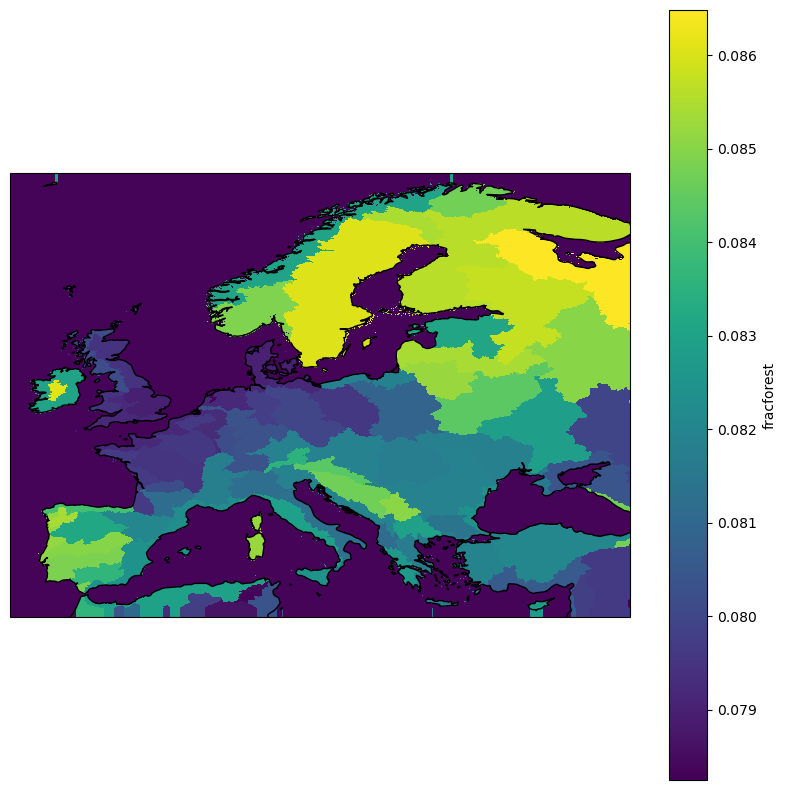

In [8]:
choosen_projection = ccrs.PlateCarree() 
land_masked_mean= land_europe.copy()
list_region = np.sort(list(set(xr_map.sub_basin.values.flatten().tolist())))
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': choosen_projection})
#ax = plt.axes(projection = choosen_projection) 
ax.set_extent([A_lon, B_lon, A_lat, B_lat], crs = choosen_projection)
ax.coastlines(linewidth=1, linestyle='-')

i = list_region[14]
land_masked=land_europe*xarr.where(xarr==i)/i 
land_masked_mean = land_masked.where(np.isnan(land_masked),land_masked.mean('time').mean('lat').mean('lon'))
land_masked_mean.fracforest.mean('time').plot(add_colorbar=True)
J=[]
for i in list_region:
    
    land_masked=land_europe*xarr.where(xarr==i)/i 
    land_masked_mean = land_masked_mean.where(np.isnan(land_masked),land_masked.mean('time').mean('lat').mean('lon'))
    # J.append(land_masked.fracforest.mean('time').mean('lat').mean('lon').values)   
    # print(J[-1])
    # land_masked_mean.fracforest.mean('time').plot(add_colorbar=False)

In [ ]:
land_masked_mean = land_masked_mean.where(np.isnan(land_masked),land_masked.mean('time').mean('lat').mean('lon'))

In [ ]:
land_masked_mean.mean('time').fracgrassland.plot()

In [ ]:
land_masked_mean.to_netcdf('/work/ch0636/g300128/Hydrologie_Calibration/data/regional_parameters/regionalized_fraclandcover.nc')

In [9]:
ds = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/regional_parameters/regionalized_fraclandcover.nc')

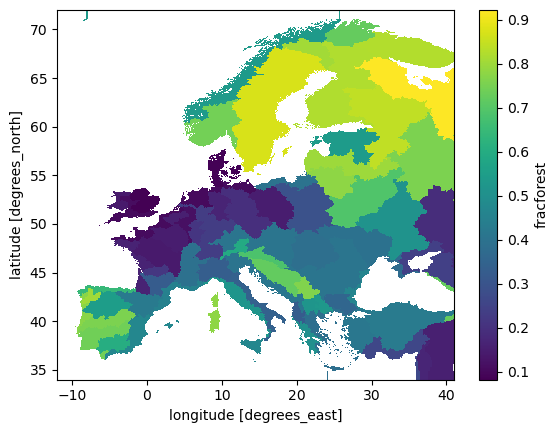

In [11]:
ds.mean('time').fracforest.plot()

## Generalization

In [6]:
def regionalising(xarr,nc_map) :
    nc_map_europe = nc_map.sel(lat = slice(B_lat,A_lat), lon = slice(A_lon,B_lon))
    nc_map_mean= nc_map_europe.copy()
    list_region = np.sort(list(set(xr_map.sub_basin.values.flatten().tolist())))
    for i in list_region: 
        nc_map_masked=nc_map_europe*xarr.where(xarr==i)/i 
        nc_map_mean = nc_map_mean.where(np.isnan(nc_map_masked),nc_map_masked.mean('lat').mean('lon'))
        region_map_mean = xr.merge([nc_map_mean,xarr])
    return(region_map_mean)
    
regionalized_variable = regionalising(xarr, variable.mean('time'))

NameError: name 'xarr' is not defined

In [ ]:
def regionalising(xarr,nc_map) :
    nc_map_europe = nc_map.sel(lat = slice(B_lat,A_lat), lon = slice(A_lon,B_lon))
    nc_map_mean= nc_map_europe.copy()
    list_region = np.sort(list(set(xr_map.sub_basin.values.flatten().tolist())))

    J=[]
    if 'time' in nc_map_mean.dims :
        for i in list_region:  
            nc_map_masked=nc_map_europe*xarr.where(xarr==i)/i 
            nc_map_mean = nc_map_mean.where(np.isnan(nc_map_masked),nc_map_masked.mean('time').mean('lat').mean('lon'))
            region_map_mean = xr.merge([nc_map_mean.mean('time'),xarr])
    else :
        for i in list_region: 
            nc_map_masked=nc_map_europe*xarr.where(xarr==i)/i 
            nc_map_mean = nc_map_mean.where(np.isnan(nc_map_masked),nc_map_masked.mean('lat').mean('lon'))
            region_map_mean = xr.merge([nc_map_mean,xarr])
    return(region_map_mean)
    


In [ ]:
list_region = list(set(xarr.values.flatten()))
data = {
    'Region': list_region,
}

variable_mean = variable.mean('time')
list_variables = list(variable_mean.variables)
for var in list_variables: 
    mean_values = []
    if (var != 'lon') & (var != 'lat'):
        for i in list_region :
            value =  regionalized_variable[var].where(regionalized_variable.sub_basin_mask==i).mean('lat').mean('lon').values
            mean_values.append(value)
        data[var] = mean_values
df = pd.DataFrame(data)

